In [1]:
import ffmpeg
import librosa
import numpy as np

In [2]:
import sys

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
sys.path.append('..')
sys.path.append('..\\tools\\visualize_app')

In [11]:
from plotter import SequenceDataGen, Plotter

In [12]:
from matplotlib import pyplot as plt, rcParams

In [13]:
start = [
    [45, -20, 20],   # 'rightMiddle'
    [45, 110, 20],   # 'rightFront'
    [-45, 110, 20],  # 'leftFront'
    [-45, -20, 20],  # 'leftMiddle'
    [0, -20, 20],    # 'leftBack'
    [0, -20, 20]     # 'rightBack'
]
end = [
    [45, -20, 20],
    [0, 110, -80],
    [-90, 110, -80],
    [-45, -20, 20],
    [0, -20, 20],
    [0, -20, 20]
]
new_end = [
    [45, -20, 20],
    [90, 110, -80],
    [0, 110, -80],
    [-45, -20, 20],
    [0, -20, 20],
    [0, -20, 20]
]

In [14]:
movement1 = [start, end]
movement2 = [start, new_end]

In [15]:
###

In [16]:
def read_wav(path):
    signal, sr = librosa.load(path)
    time = np.linspace(0, 1 / sr * len(signal), num=len(signal))
    return {'signal': signal, 'time': time, 'sr': sr}


def extract_beats(audio_dict):
    tempo, beats = librosa.beat.beat_track(y=audio_dict['signal'], sr=audio_dict['sr'])
    beats_time = librosa.frames_to_time(beats, sr=audio_dict['sr'])
    return beats_time

In [17]:
audio_d = read_wav('New-Composition-_3.wav')

In [18]:
ix = 220500

In [19]:
audio_d['signal']= audio_d['signal'][0:ix]

In [20]:
beats = extract_beats(audio_d)

In [21]:
beats

array([0.60371882, 1.11455782, 1.64861678, 2.15945578, 2.69351474,
       3.20435374, 3.7384127 , 4.2492517 , 4.78331066, 5.29414966,
       5.82820862, 6.33904762, 6.87310658, 7.38394558, 7.91800454,
       8.42884354, 8.96290249])

In [22]:
### generate sequence

In [23]:
fps = 60
vid_dt = 1./fps

In [24]:
vid_dt

0.016666666666666666

In [25]:
s = SequenceDataGen()

In [26]:
for ix in range(1):
    n_frames = int((beats[ix+1]-beats[ix])/vid_dt)
    s.get_sequence(start_pose=start, end_pose=end, n_frames=n_frames, reverse=False)

In [ ]:
###

In [27]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [51]:
def draw_hexapod(leg_lines, body_poly, body_vertices, save_dir = ''):

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # stand_pts = [
    #     [-300, -300, 0],
    #     [300, -300, 0],
    #     [300, 300, 0],
    #     [-300, 300, 0]
    # ]
    figs_list = []
    for i in range(len(leg_lines)):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        # plt.cla()
        # plt.gcf().canvas.mpl_connect('key_release_event',
        #                              lambda event: [exit(0) if event.key == 'escape' else None])

        # plot base stand polygon
        # base_poly = Poly3DCollection([stand_pts], alpha=0.5)
        # ax.add_collection3d(base_poly)

        # plot hexapod body polygon
        poly = Poly3DCollection([body_poly[i]], alpha=0.5)
        ax.add_collection3d(poly)
        # plot poly vertices
        ax.plot(body_vertices[i][0], body_vertices[i][1], body_vertices[i][2])
        ax.scatter(body_vertices[i][0], body_vertices[i][1], body_vertices[i][2])
        # plot legs
        for leg in leg_lines[i]:
            ax.plot(leg[0], leg[1], leg[2])
            ax.scatter(leg[0], leg[1], leg[2])

        # remove axis info
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0

        # setup current frame settings
        ax.set_xlim3d([-400,400])
        ax.set_ylim3d([-400,400])
        ax.set_zlim3d([0,300])
        # ax.margins(x=0, y=-0.25, z=50)
        # ax.set_aspect('equal')
        ax.view_init(elev=30, azim=75)
        figs_list.append(fig)
        if save_dir:
            plt.savefig(f'{save_dir}/{str(i).zfill(3)}.png')


        plt.pause(0.1)
    return figs_list


In [54]:
(
 ffmpeg
 .input("../figs/*.png", pattern_type='glob', framerate=fps)
 .output("movie.mp4")
 .run()
)

AttributeError: module 'ffmpeg' has no attribute 'input'

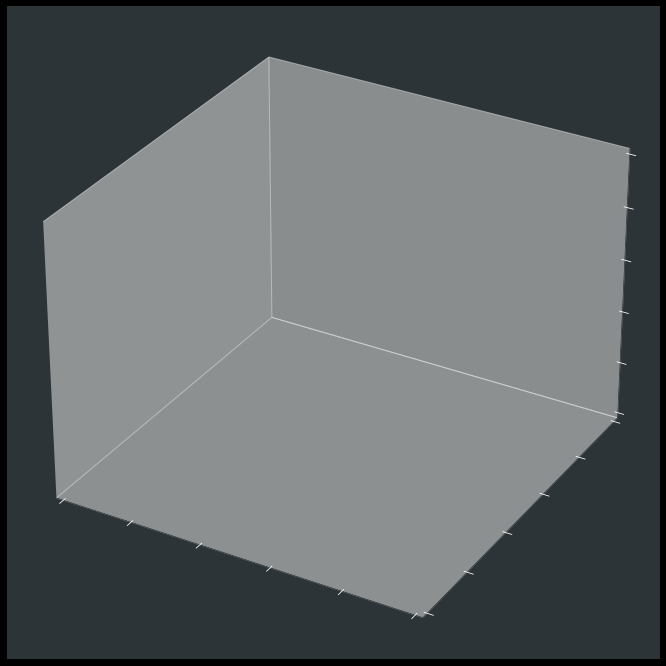

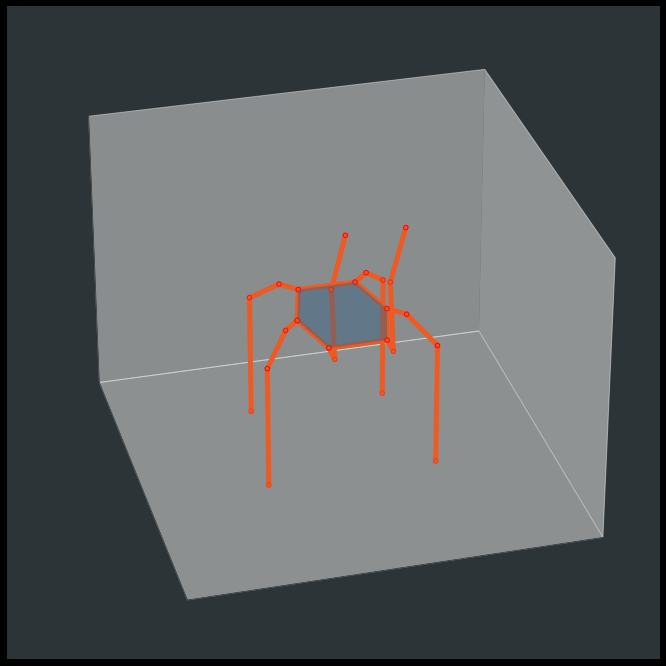

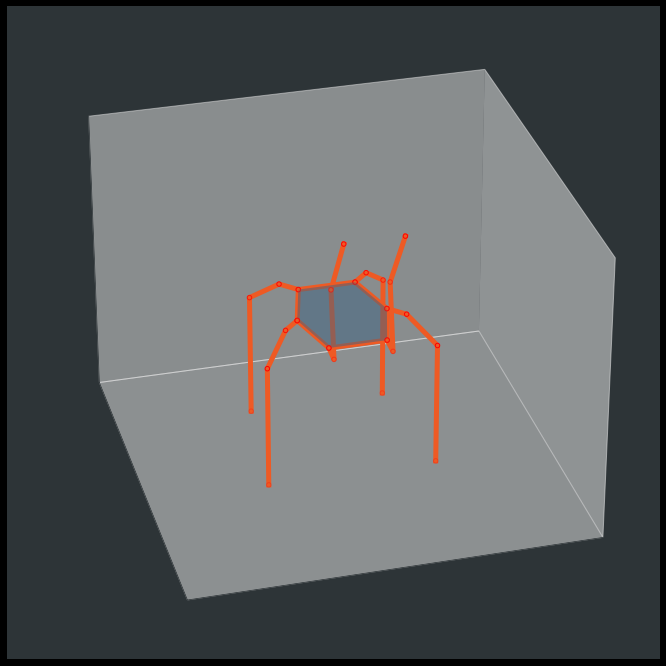

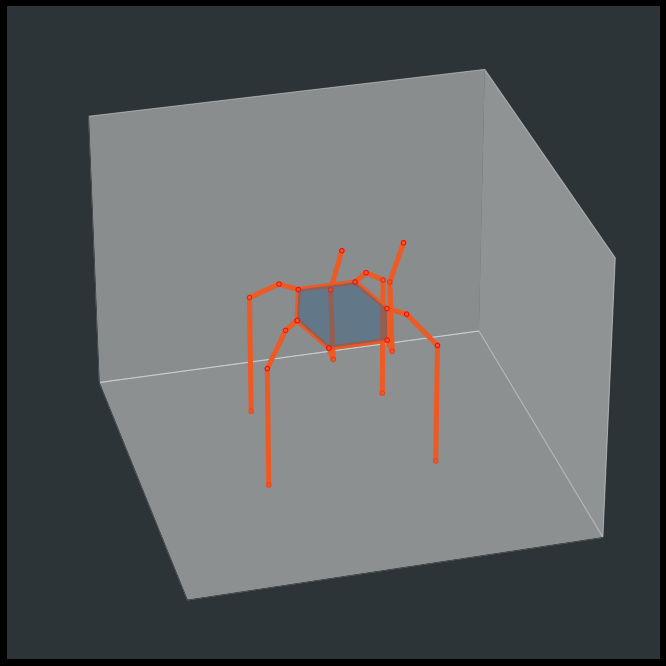

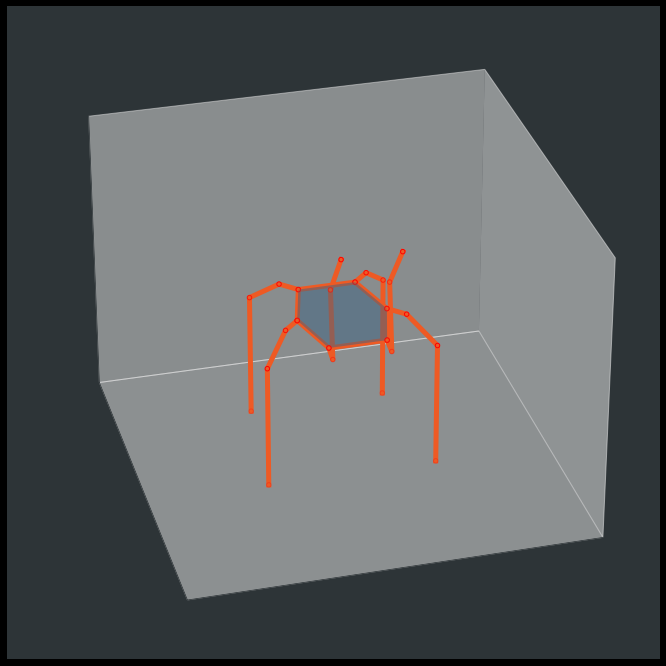

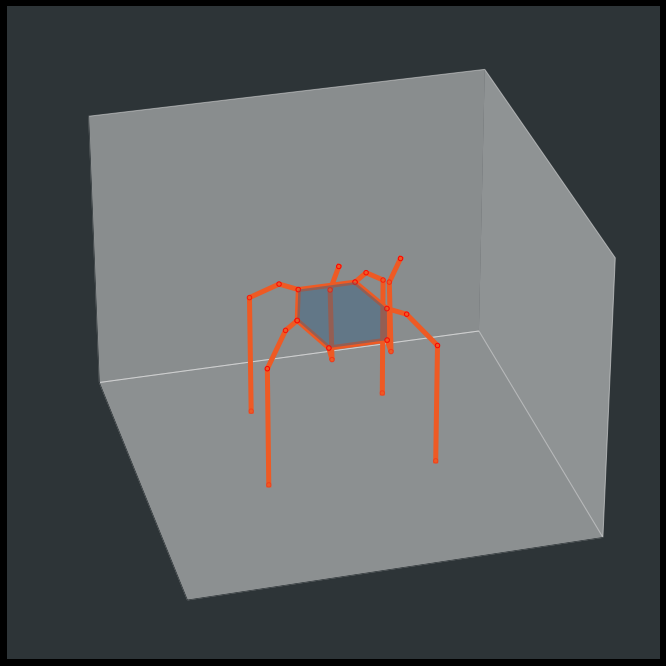

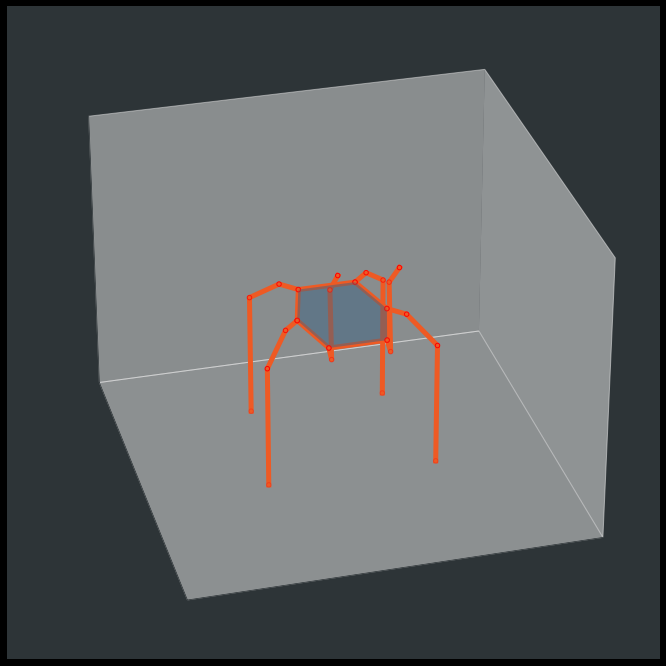

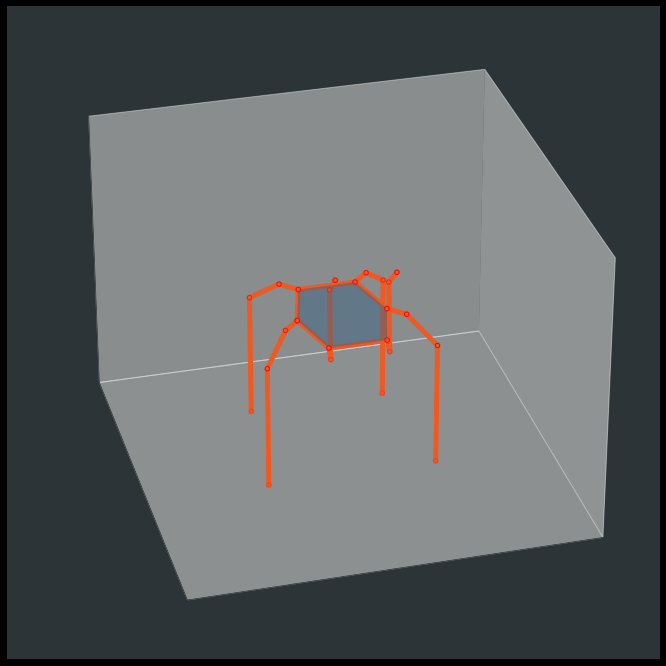

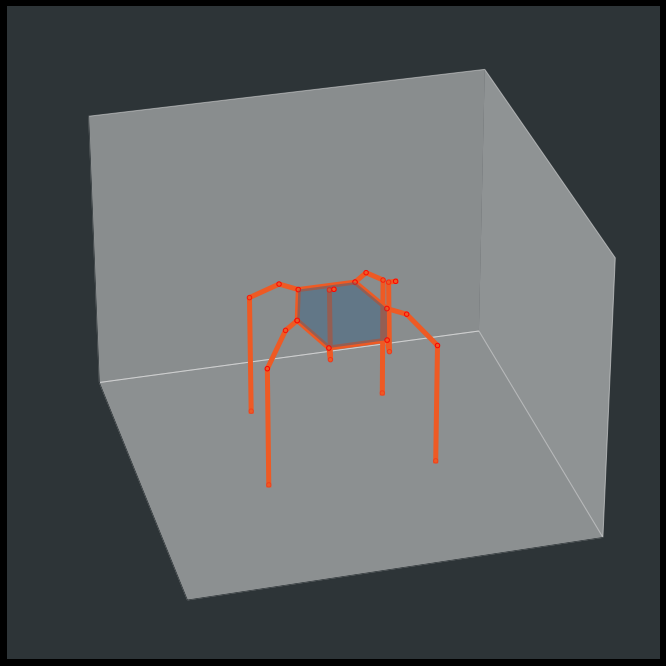

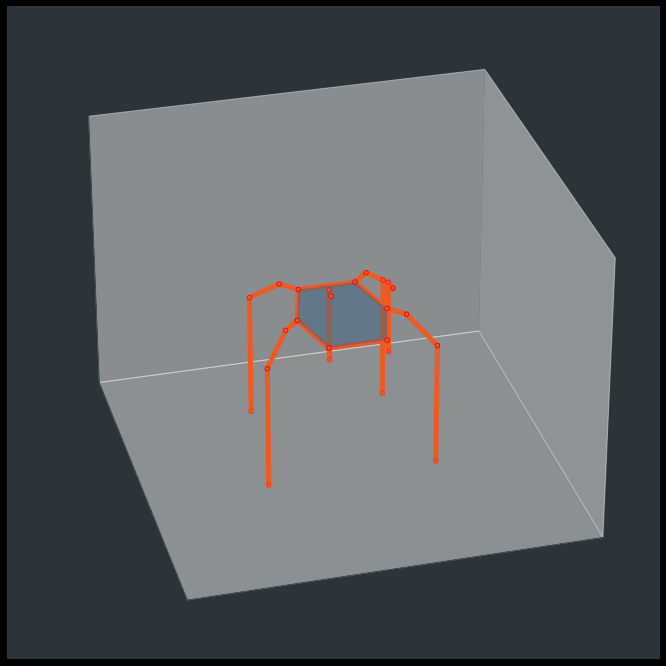

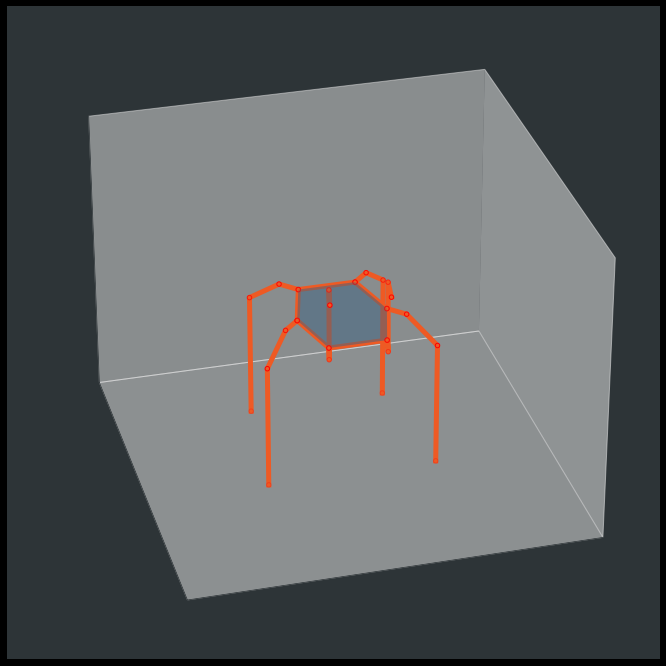

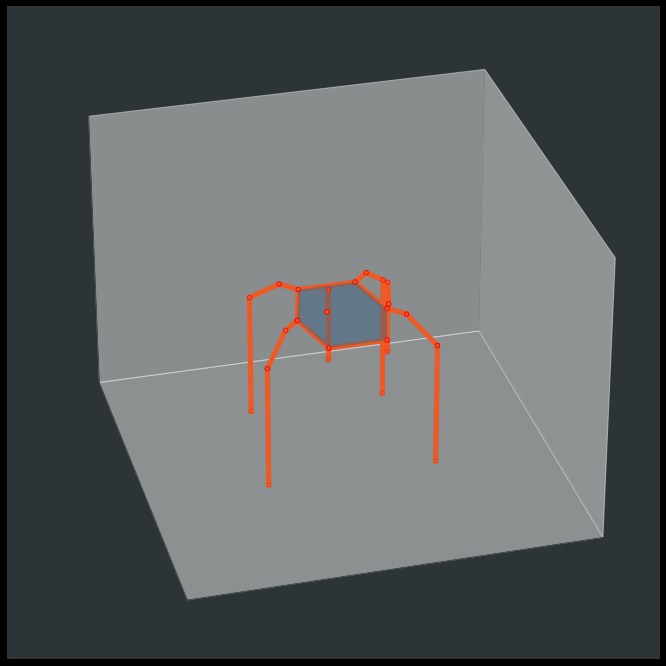

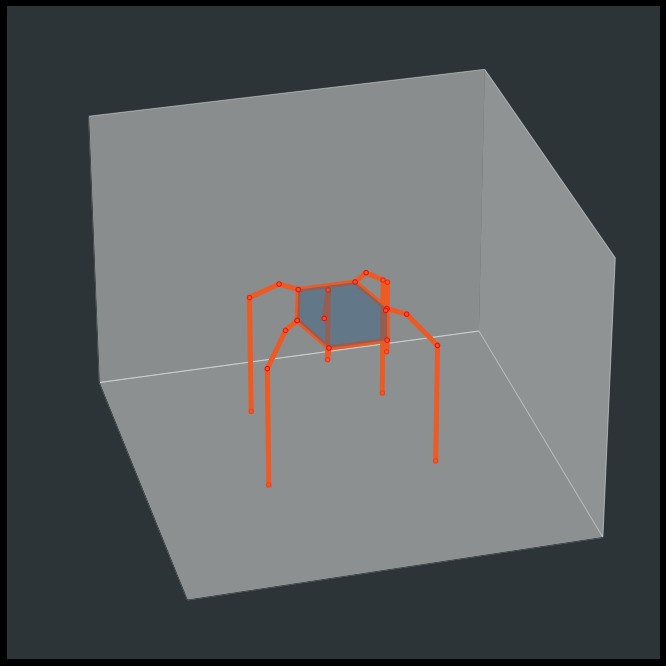

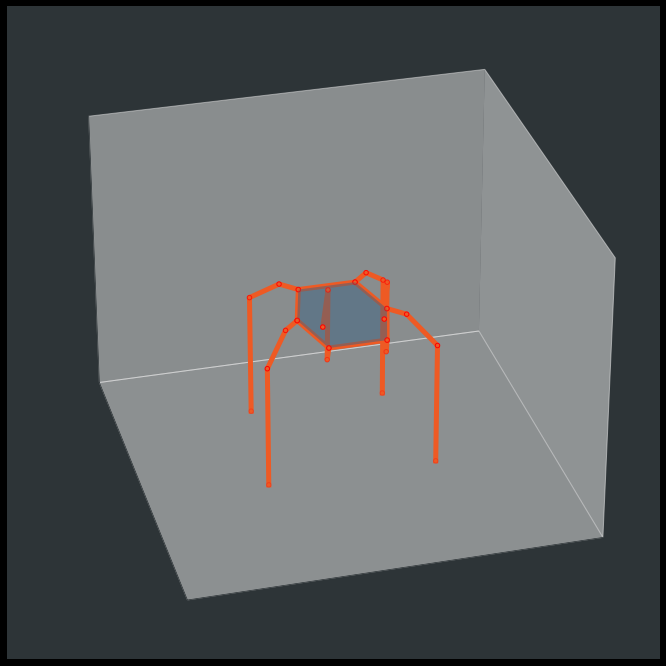

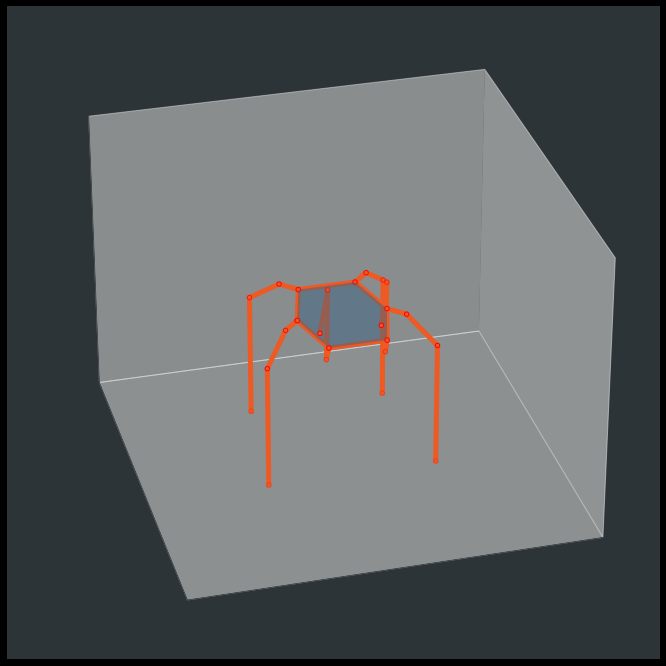

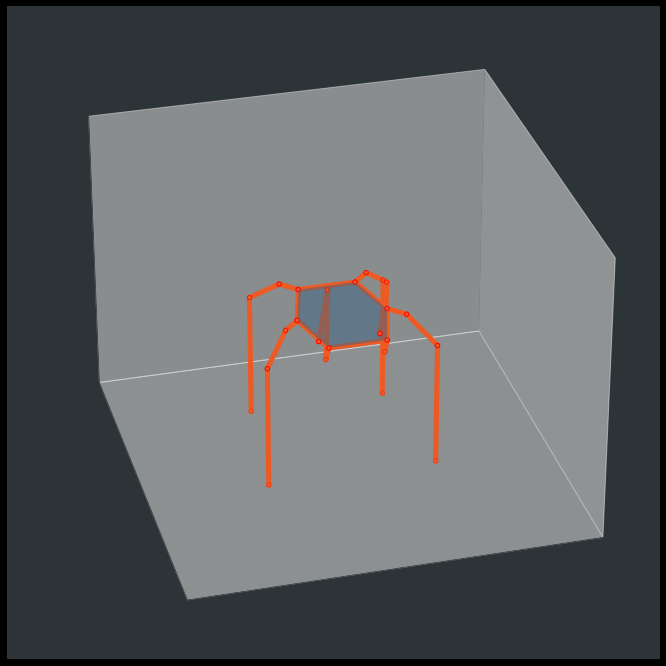

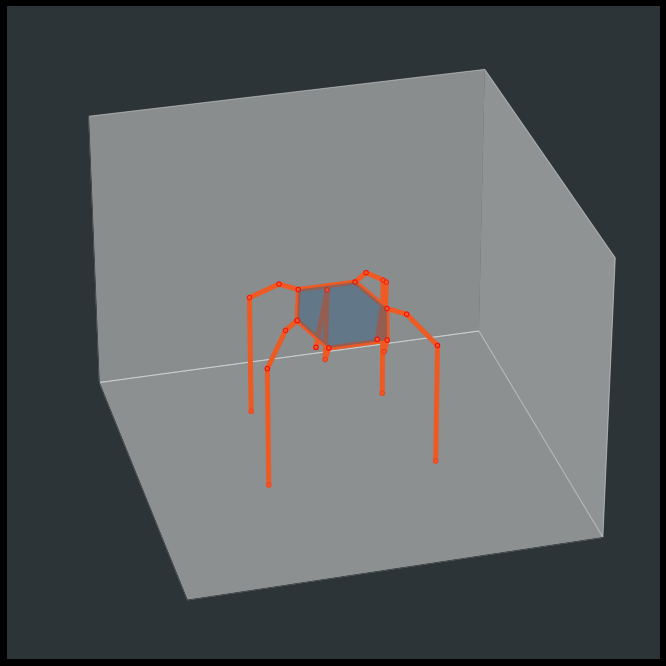

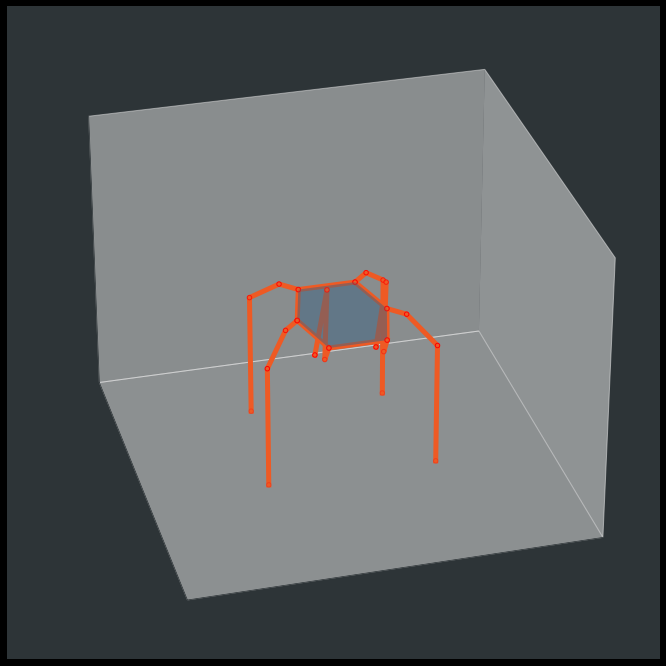

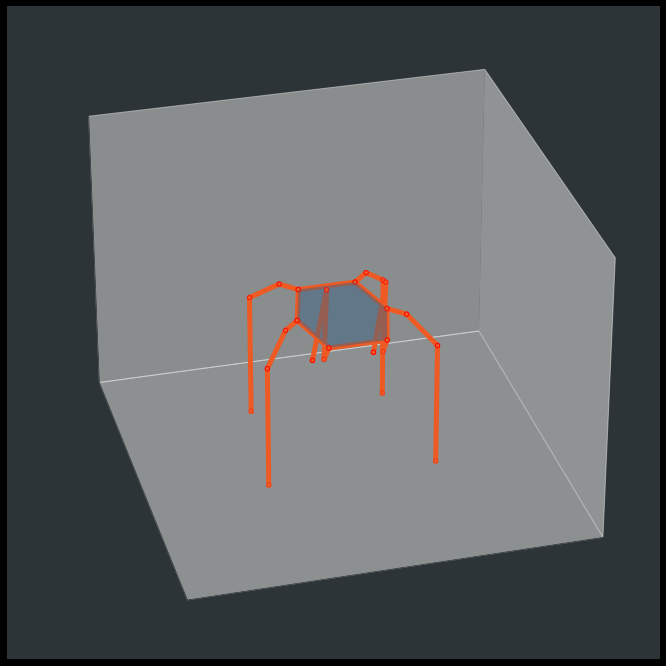

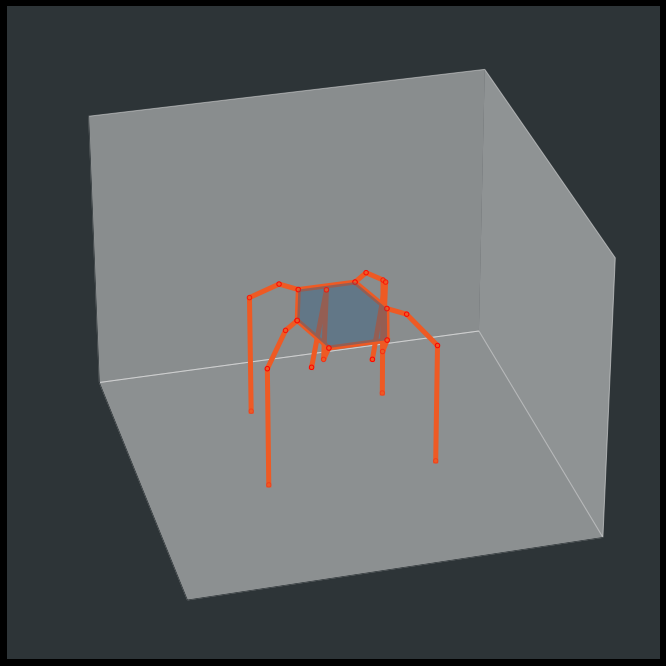

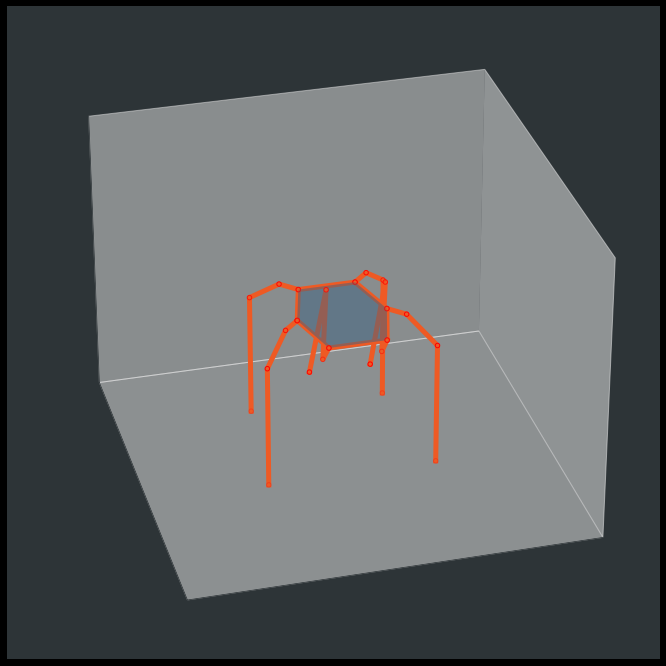

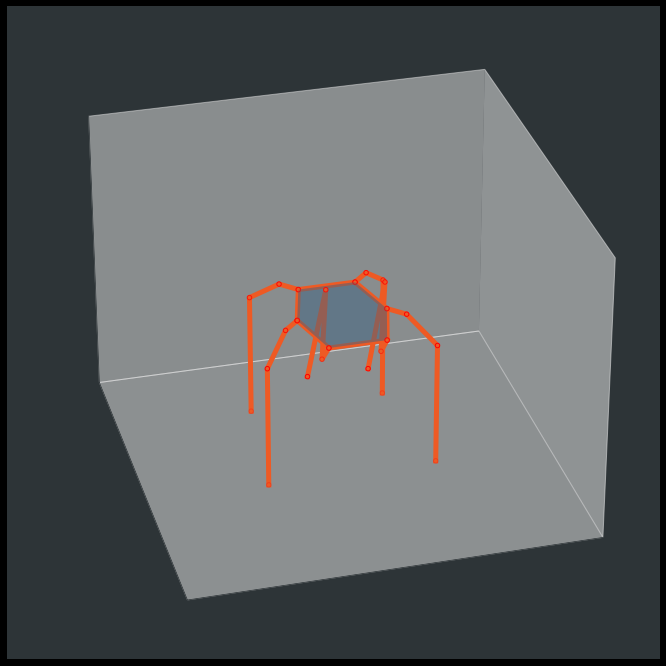

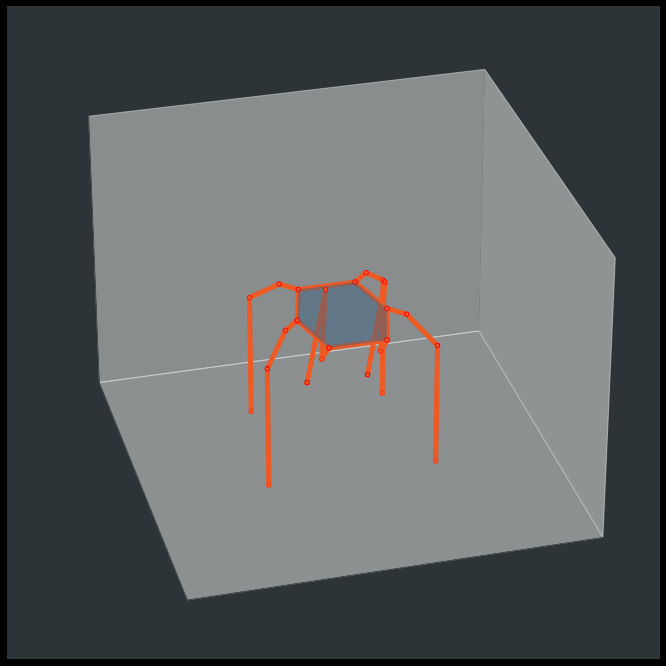

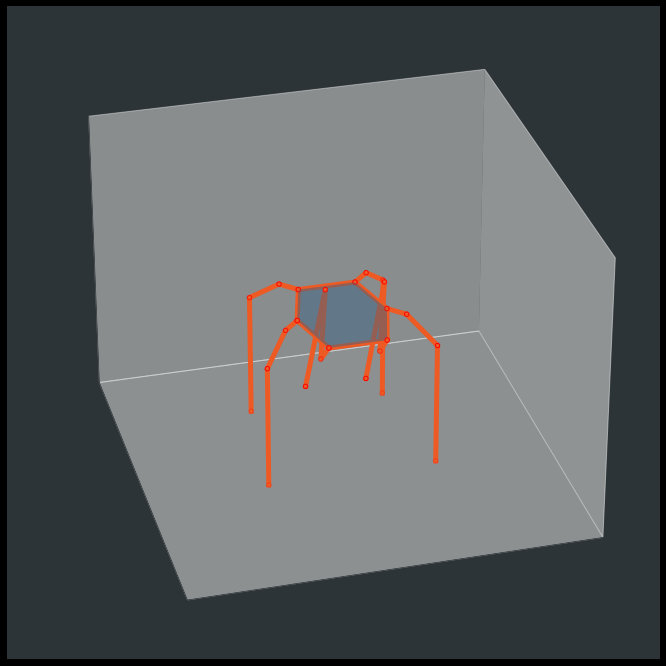

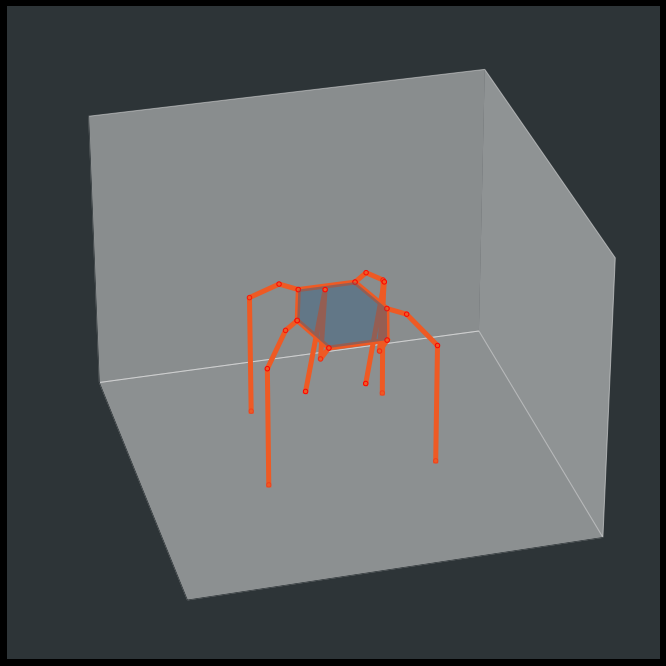

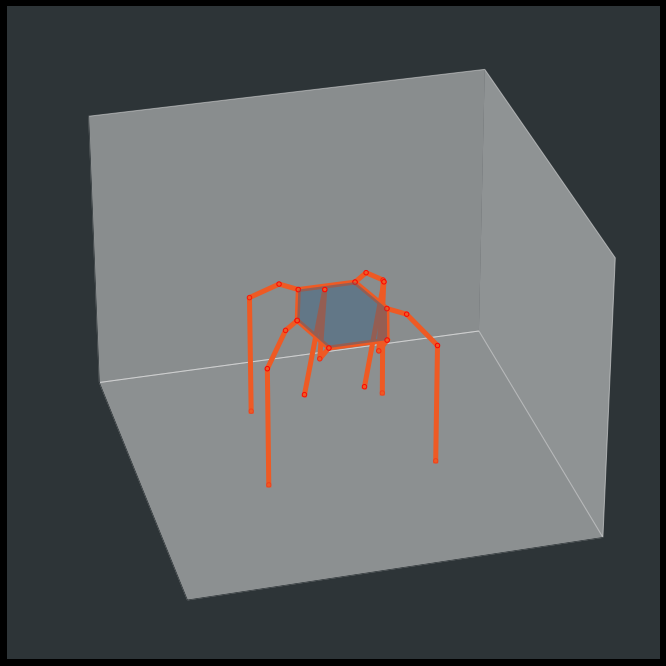

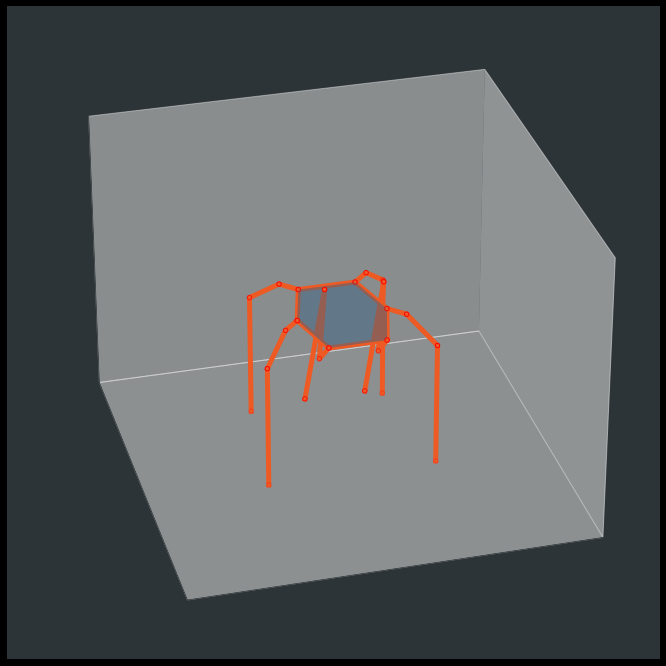

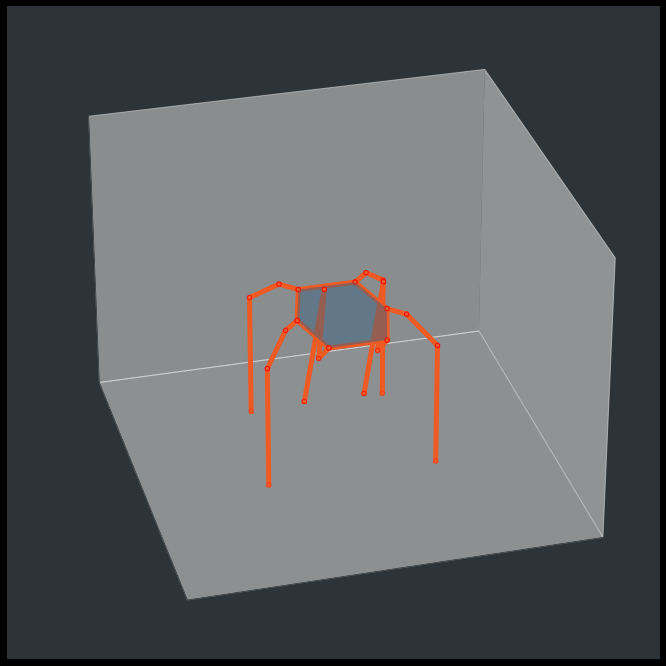

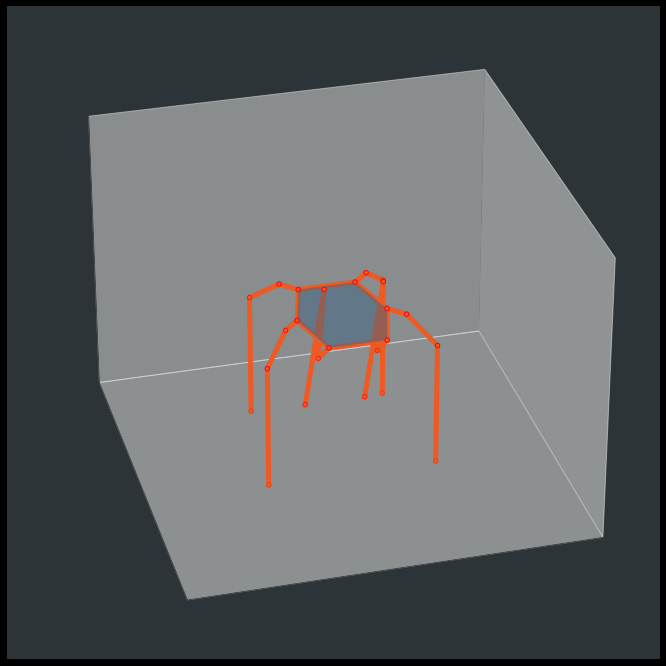

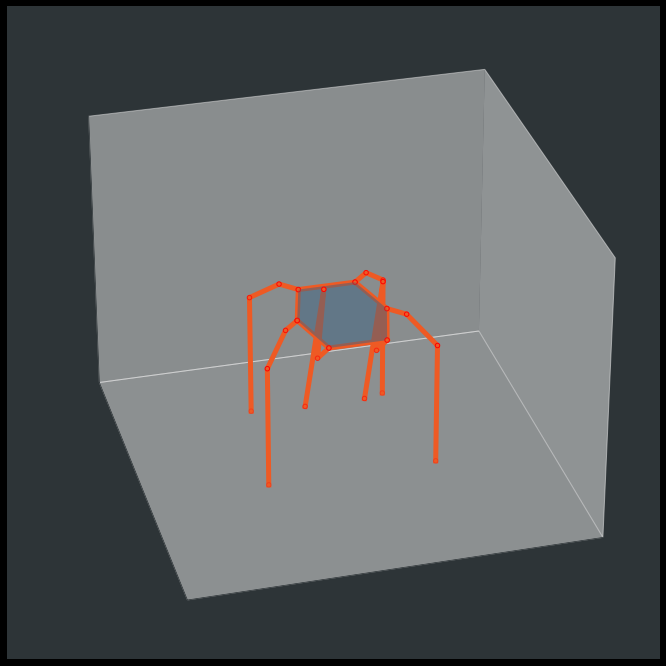

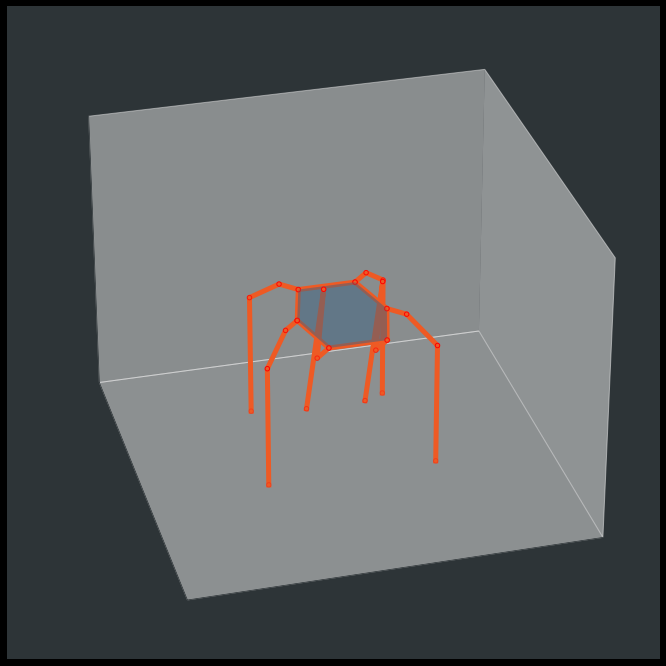

In [53]:
f_l = draw_hexapod(s.leg_lines, s.body_poly, s.body_vertices, save_dir = 'figs')

In [ ]:
###

In [ ]:
Plotter(savefig=True, save_dir='figs').draw_hexapod(s.leg_lines, s.body_poly, s.body_vertices)

In [ ]:
len(s.leg_lines)